In [35]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np
from scipy import stats
from dieboldmariano import dm_test

In [36]:
df1 = pd.read_csv('lstm_baseline.csv')

print(df1.head())

         Date    Actual  Predicted
0  2014-01-24  0.006968   0.005303
1  2014-01-27  0.006996   0.006565
2  2014-01-28  0.007142   0.007071
3  2014-01-29  0.007384   0.007284
4  2014-01-30  0.007886   0.007557


In [37]:
y_true = df1['Actual']
y_pred_lstm=df1['Predicted']

In [38]:
df2 = pd.read_csv('hybrid_baseline.csv')

print(df2.head())

         Date    Actual  Predicted
0  2014-01-24  0.006968   0.005308
1  2014-01-27  0.006996   0.006956
2  2014-01-28  0.007142   0.007305
3  2014-01-29  0.007384   0.007484
4  2014-01-30  0.007886   0.007653


In [39]:
y_pred_sv_lstm = df2['Predicted']


# 2. Calculate absolute errors (can also use squared errors)
error_sv_lstm = abs(y_true - y_pred_sv_lstm)
error_lstm = abs(y_true - y_pred_lstm)

# 3. Compute the difference in errors
error_diff = error_sv_lstm - error_lstm

# 4. Perform Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(error_diff)

print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value:.20f}")

if p_value < 0.05:
    print("Significant difference between SV-LSTM and LSTM forecasts.")
else:
    print("No significant difference between the models.")

Wilcoxon test statistic: 1544740.0
P-value: 0.05817887876286071541
No significant difference between the models.


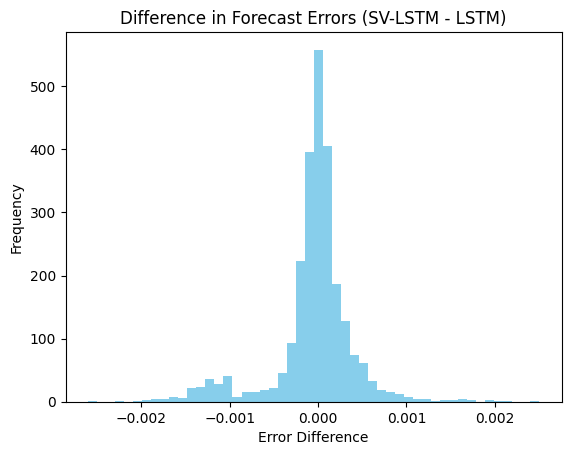

In [40]:
import matplotlib.pyplot as plt

plt.hist(error_diff, bins=50, color='skyblue')
plt.title('Difference in Forecast Errors (SV-LSTM - LSTM)')
plt.xlabel('Error Difference')
plt.ylabel('Frequency')
plt.show()

In [41]:
def diebold_mariano(e1, e2, h=1, power=2):
    """
    e1, e2: forecast errors from two models
    h: forecast horizon
    power: loss function power (2 = MSE, 1 = MAE)
    """
    d = np.abs(e1) ** power - np.abs(e2) ** power  # loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    DM_stat = mean_d / np.sqrt((var_d / len(d)))
    p_value = 2 * stats.norm.cdf(-abs(DM_stat))
    return DM_stat, p_value

In [42]:
# Apply Diebold-Mariano test
dm_stat, dm_p = diebold_mariano(error_sv_lstm, error_lstm, h=1, power=2)
print(f"Diebold-Mariano statistic: {dm_stat:.4f}, p-value: {dm_p:.8f}")

Diebold-Mariano statistic: -6.8555, p-value: 0.00000000


In [43]:
ks_stat, ks_p = stats.ks_2samp(y_pred_sv_lstm, y_pred_lstm)
print(f"Kolmogorov-Smirnov statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

Kolmogorov-Smirnov statistic: 0.0303, p-value: 0.1938


In [52]:
# Apply Diebold-Mariano test
dm_stat3, dm_p3 = diebold_mariano(error_sv_lstm, error_lstm, h=1, power=1)
print(f"Diebold-Mariano statistic: {dm_stat3:.4f}, p-value: {dm_p3:.8f}")

Diebold-Mariano statistic: -5.5140, p-value: 0.00000004


In [51]:
dm_stat4, dm_p4 = diebold_mariano(error_sv_lstm, error_lstm, h=1, power=1)  # Absolute error
print(f"DM Statistic (MAE): {dm_stat4:.4f}, P-value: {dm_p4:.8f}")


DM Statistic (MAE): -5.5140, P-value: 0.00000004


In [46]:
dm_test, dm_p2 = dm_test(y_true, y_pred_sv_lstm, y_pred_lstm, one_sided=False)
print(f"Diebold-Mariano Test Statistic: {dm_test}")
print(f"P-value: {dm_p2}")

Diebold-Mariano Test Statistic: -6.855525702794906
P-value: 8.887555630205463e-12


In [47]:
mse_lstm = np.mean((y_true - y_pred_lstm) ** 2)
mse_sv_lstm = np.mean((y_true - y_pred_sv_lstm) ** 2)
print(f"MSE LSTM: {mse_lstm}, MSE SV-LSTM: {mse_sv_lstm}")


MSE LSTM: 7.087086163682974e-07, MSE SV-LSTM: 5.071173179974377e-07


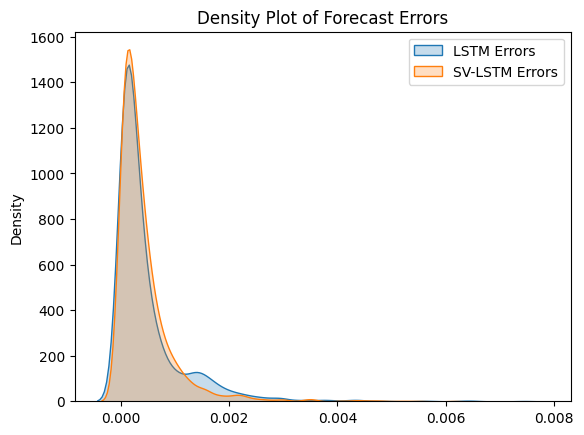

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(error_lstm, label="LSTM Errors", fill=True)
sns.kdeplot(error_sv_lstm, label="SV-LSTM Errors", fill=True)
plt.legend()
plt.title("Density Plot of Forecast Errors")
plt.show()


In [49]:

# Define functions
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Compute error metrics
mse_lstm = mse(y_true, y_pred_lstm)
mae_lstm = mae(y_true, y_pred_lstm)
mape_lstm = mape(y_true, y_pred_lstm)

mse_sv_lstm = mse(y_true, y_pred_sv_lstm)
mae_sv_lstm = mae(y_true, y_pred_sv_lstm)
mape_sv_lstm = mape(y_true, y_pred_sv_lstm)

# Display results in scientific notation

def sci_format(val):
    return f"{val:.2e}".replace("e-0", "e-").replace("e+", "e")

def format_as_10(val):
    # Convert to scientific notation like: 1.29 * 10^(-5)
    base, exp = f"{val:.2e}".split('e')
    return f"{base} × 10^{int(exp)}"

# Display results
print("LSTM Model:")
print(f"MSE: {format_as_10(mse_lstm)}")
print(f"MAE: {format_as_10(mae_lstm)}")
print(f"MAPE: {(mape_lstm)}")


print("\nSV-LSTM Model:")
print(f"MSE: {format_as_10(mse_sv_lstm)}")
print(f"MAE: {format_as_10(mae_sv_lstm)}")
print(f"MAPE: {(mape_sv_lstm)}")

LSTM Model:
MSE: 7.09 × 10^-7
MAE: 4.80 × 10^-4
MAPE: 5.290680302068335

SV-LSTM Model:
MSE: 5.07 × 10^-7
MAE: 4.29 × 10^-4
MAPE: 4.747001835613331
